# COVID-19 Infection curve analysis                                                                      
## Naoaki ONO nono@is.nasit.jp   

CoViD-19 infection curve (in Japan, from Jan. 15, 2020) analysis using R.

The numbers of infected and tested by PCR have been gathered from the website of Ministry of Health, Labour and Welfare, Japan

Sources and data are available on GitHub.
https://github.com/naono-git/covid19

Open using [nbviewer service](https://nbviewer.jupyter.org/github/naono-git/covid19/blob/master/covid19.nara.ipynb)


### Nara model

Tentative prediciton of infection in Nara prefecture based on Total and Kinki model.

In [86]:
library(date)
source("src/plotUtil.R")

First, we evaluate total Japan corona virus infection.

And assume the exponential model to evaluate the initial growth curve.

In [87]:
# covid <- read.delim("data/covid19.txt", header=TRUE, sep="\t")
covid <- read.delim("data/covid19.total.txt", header=TRUE, sep="\t")
nd <- nrow(covid)

covid.kyoto <- read.delim("data/covid19.kyoto.txt", header=TRUE, sep="\t")
covid.osaka <- read.delim("data/covid19.osaka.txt", header=TRUE, sep="\t")
covid.nara <- read.delim("data/covid19.nara.txt", header=TRUE, sep="\t")
covid.hyogo <- read.delim("data/covid19.hyogo.txt", header=TRUE, sep="\t")

population4 <- c(kyoto=2599, osaka=8823, nara=1348, hyogo=5503)

stamp <- paste(c(covid[nd,1],sprintf("%02d",covid[nd,2]),sprintf("%02d",covid[nd,3])),collapse="")
stamp

[1] "20200414"

In [88]:
ddd <- mdy.date(month=covid$mm, day=covid$dd, year=covid$yy)
d0  <- ddd[1]
dd1 <- ddd-d0 ## relative date starting from 2020/01/15                                                   
dd1[1] <- 7   ## initial offset (aribtrary chosen) 

In [89]:
## dates to plot ticks                                                                                    
mdlabel <- rbind(c(1,15),
                 c(2, 1),
                 c(2,15),
                 c(3, 1),
                 c(3,15),
                 c(4, 1),
                 c(4,15),
                 c(5, 1),
                 c(5,15),
                 c(6, 1),
                 c(6,15),
                 c(7, 1),
                 c(7,15)
                )
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})
## label to plot ticks                                                                                    
ticklabel <- apply(mdlabel,1,paste,collapse="/")

In [90]:
logd <- log(dd1)        ## log day
logi <- log(covid$i)    ## log number of infected                                                               
logp <- log(covid$PCR)  ## log number of PCR

In [91]:
daydiff <- function(xx){
    return(xx - c(0,xx[-length(xx)]))
}
pred_pow <- function(xx,cc,ll){
    return(xx^ll*exp(cc))
}
pred_exp <- function(xx,cc,ll){
    return(cc*exp(ll*xx))
}

We compared the power model and the exponential model.

It seems difficult to evaluate quantitatively.

Maybe, log-likelihood and free energy or, WAIC would be useful.

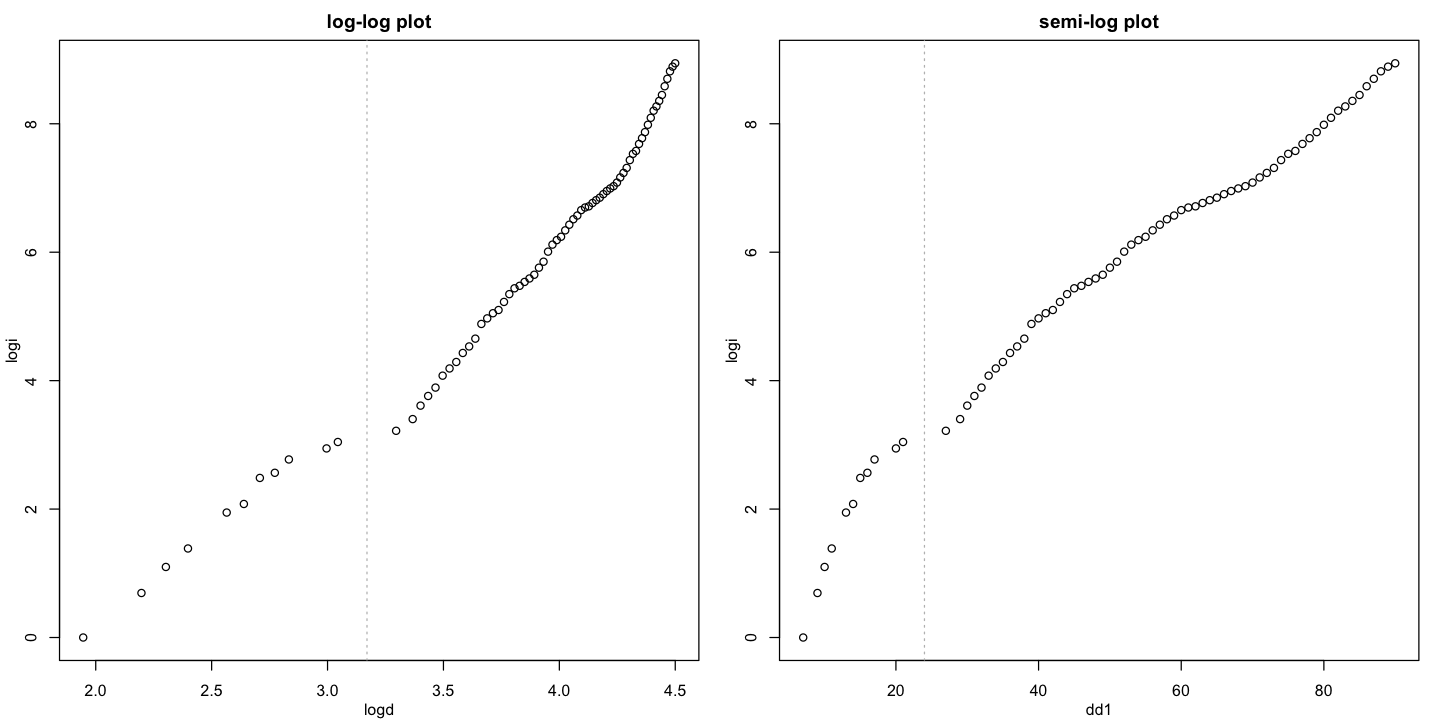

In [92]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfcol=c(1,2))
par.margin("smart")

plot(logd, logi, main="log-log plot")
abline(v=mean(logd[11:12]), lty=3, col=8)
# abline(-2,2,lty=3, col=2)

plot(dd1, logi, main="semi-log plot")
abline(v=mean(dd1[11:12]), lty=3, col=8)
## ... Do you think which looks more linearly?

In [93]:
## Fitting by power. 1, fit for the earlier stage                                                   
model_pow_0 <- lm(logi~logd)
model_pow_0

model_pow_1 <- lm(logi[1:11]~logd[1:11])
model_pow_1

## Fitting by power. 2, fit for the latter stage                                                   
model_pow_2 <- lm(logi[12:nd]~logd[12:nd])
model_pow_2


Call:
lm(formula = logi ~ logd)

Coefficients:
(Intercept)         logd  
     -7.382        3.433  



Call:
lm(formula = logi[1:11] ~ logd[1:11])

Coefficients:
(Intercept)   logd[1:11]  
     -5.562        2.894  



Call:
lm(formula = logi[12:nd] ~ logd[12:nd])

Coefficients:
(Intercept)  logd[12:nd]  
    -11.732        4.495  


We also applided exponential fitting.

Since there seems a significant change in the growth at 2/11 (gray line), we focused on the latter period.

In [94]:
## We focus on the latter growth (D > Feb. 11th)
model_exp_2 <- lm(logi[12:nd]~dd1[12:nd])
model_exp_2
cc_exp_2 <- exp(model_exp_2$coefficients[1])
ll_exp_2 <- model_exp_2$coefficients[2]


Call:
lm(formula = logi[12:nd] ~ dd1[12:nd])

Coefficients:
(Intercept)   dd1[12:nd]  
    1.51368      0.08216  


## Kinki area

First, we apply the linear model, as a initial approximation of the SIR model.

In general, the dynamics of infection is described by the "SIR" model.
$$
\frac{dS}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I,
$$
where S denotes the population ratio of susceptible, I denotes infected, R denotes recoverd, respectively, and $\beta$ and $\gamma$ are the coefficient of infection and recovery.

Where the growth looks linear in the semi-log prot, we can expect the simplest growth dynamics,

$$
\frac{dI}{dt} = \lambda I \\
I(t) = I_0 \exp(\lambda t) \\
\log(I) = \lambda t + C_0
$$



kinki.jpg 


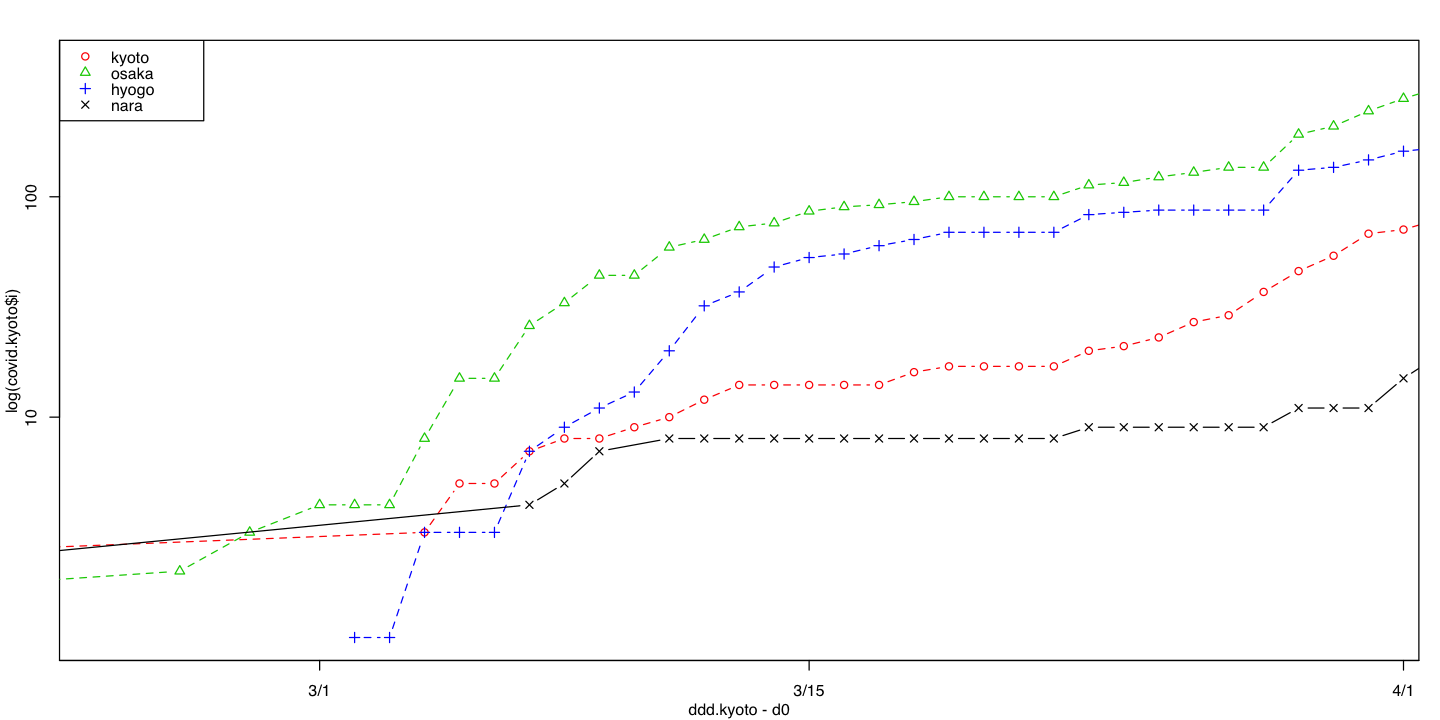

In [95]:
ddd.kyoto <- mdy.date(month=covid.kyoto$mm, day=covid.kyoto$dd, year=covid.kyoto$yy)
ddd.osaka <- mdy.date(month=covid.osaka$mm, day=covid.osaka$dd, year=covid.osaka$yy)
ddd.nara  <- mdy.date(month=covid.nara$mm,  day=covid.nara$dd,  year=covid.nara$yy )
ddd.hyogo <- mdy.date(month=covid.hyogo$mm, day=covid.hyogo$dd, year=covid.hyogo$yy)
logi.nara <- log(covid.nara$i)
plotFigure(function(){
    par.margin("smart")
    plot(  ddd.kyoto-d0, log(covid.kyoto$i), type="b", col=2, lty=2, xlim=c(40,76), ylim=c(0,6), pch=1, axes=FALSE, frame=TRUE)
    points(ddd.osaka-d0, log(covid.osaka$i), type="b", col=3, lty=2, pch=2)
    points(ddd.hyogo-d0, log(covid.hyogo$i), type="b", col=4, lty=2, pch=3)
    points(ddd.nara -d0, log(covid.nara$i ), type="b", col=1, pch=4)
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))

    legend("topleft", col=c(2,3,4,1), pch=c(1,2,3,4), legend=c("kyoto", "osaka", "hyogo", "nara"))
}, dir="fig", file="kinki", dev=c("x11", "jpg"))

To predict the number of infected people in the nearest two or four weeks, we evaluate the growth of the neighbouring prefectures, in the latest two weeks.

And averaged their growth rate with the weights of their populations to obtain "kinki growth rate".

Since the kinki rate was somehow smaller that of entire Japan, it may be better to estimate by a weighted mean between kinki-rate and total-rate...

In [106]:
dd <- 14
covid3 <- list(kyoto=covid.kyoto, osaka=covid.osaka, nara=covid.nara, hyogo=covid.hyogo)
source3 <- c("kyoto","osaka","hyogo")
lm3 <- list()
ll3 <- numeric(3)
for(aa in 1:3){
    ss <- source3[aa]
    covid_tmp <- covid3[[ss]]

    nd <- nrow(covid_tmp)
    ddd_tmp <- mdy.date(month=covid_tmp$mm, day=covid_tmp$dd, year=covid_tmp$yy)
    xx <- ddd_tmp[(nd-dd):nd]-d0
    yy <- log(covid_tmp$i[(nd-dd):nd])
    tmp <- lm(yy~xx)    
    ll3[aa] <- tmp$coefficients[2]
    lm3[[ss]] <- tmp
}
ll_all <- ll_exp_2[[1]]
ll_all

ll_kinki <- sum(ll3 * population4[c("kyoto", "osaka", "hyogo")]) /sum(population4[c("kyoto", "osaka", "hyogo")])
ll_kinki


[1] 0.08216101

[1] 0.09012959

In [97]:

tmp  <- optimize(function(par){ mean( (exp((ddd.nara-d0 )*ll_kinki+par) - covid.nara$i )^2)}, c(-5,5))
tmp$minimum


[1] -4.161095

In [98]:
iii <- (nd_nara-6):nd_nara
covid.nara[iii,]

,yy,mm,dd,i,d,PCR
,<int>,<int>,<int>,<int>,<int>,<lgl>
28,2020,4,3,21,0,NA
29,2020,4,4,24,0,NA
30,2020,4,5,25,0,NA
31,2020,4,6,26,0,NA
32,2020,4,7,28,0,NA
33,2020,4,8,30,0,NA
34,2020,4,9,34,0,NA


In [114]:
nd_nara <- nrow(covid.nara)
iii <- (nd_nara-6):nd_nara
tmp.kinki <- optimize(function(par){ mean( (exp((ddd.nara[iii]-d0 )*ll_kinki+par) - covid.nara$i[iii] )^2)}, c(-5,5))
cc_kinki <- exp(tmp.kinki$minimum)
cc_kinki

tmp.all <- optimize(function(par){ mean( (exp((ddd.nara[iii]-d0 )*ll_all+par) - covid.nara$i[iii] )^2)}, c(-5,5))
cc_all <- exp(tmp.all$minimum)
cc_all

[1] 0.01521429

[1] 0.03036513

kinki.jpg 


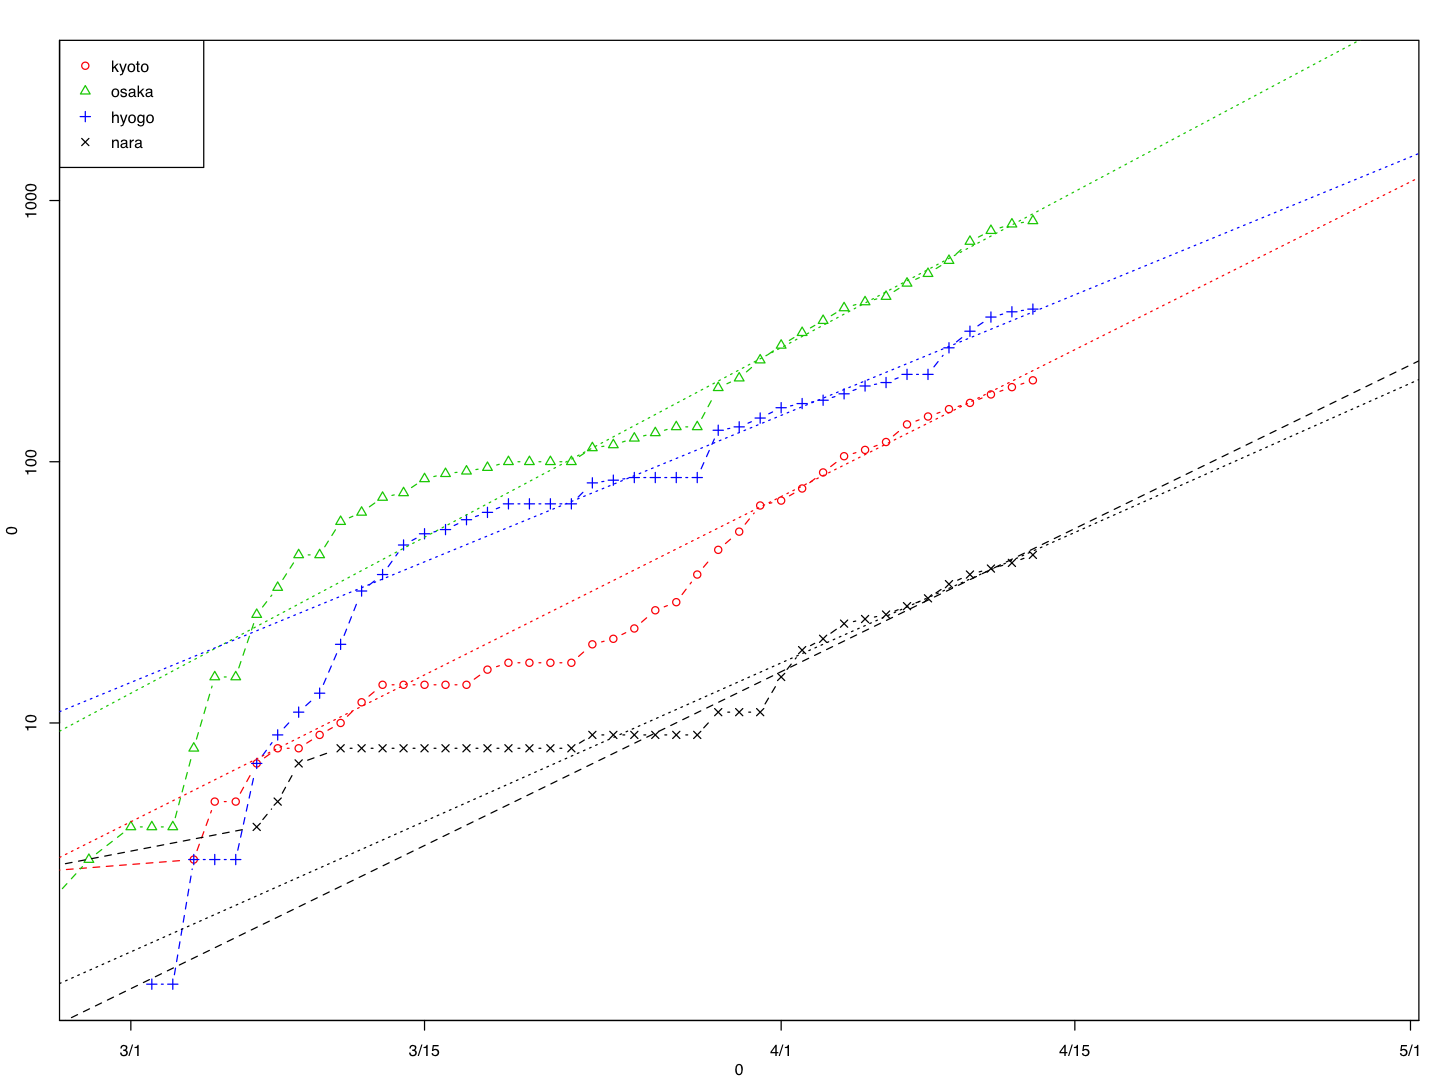

In [110]:
options(repr.plot.width=12, repr.plot.height=9)

plotFigure(function(){
    par.margin("smart")
    plot(0, 0, type="n", xlim=c(45,105), ylim=c(0,8), pch=1, axes=FALSE, frame=TRUE)
    points(ddd.kyoto-d0, log(covid.kyoto$i), type="b", col=2, lty=2, pch=1)
    points(ddd.osaka-d0, log(covid.osaka$i), type="b", col=3, lty=2, pch=2)
    points(ddd.hyogo-d0, log(covid.hyogo$i), type="b", col=4, lty=2, pch=3)
    points(ddd.nara -d0, log(covid.nara$i ), type="b", col=1, lty=2, pch=4)
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))
    abline(lm3[["kyoto"]],col=2,lty=3)
    abline(lm3[["osaka"]],col=3,lty=3)
    abline(lm3[["hyogo"]],col=4,lty=3)
    abline(log(cc_kinki), ll_kinki, lty=2)
    abline(log(cc_total), ll_exp_2, lty=3)
    legend("topleft", col=c(2,3,4,1), pch=c(1,2,3,4), legend=c("kyoto", "osaka", "hyogo", "nara"))
},rr=1.5, dir="fig", file="kinki", dev=c("x11", "jpg"))

Using the estimated growth rate, we can compute the population coefficient of the exponential curve.

In [111]:
exp(ll_all)
exp(ll_kinki)

log(2) / (ll_all)
log(2) / (ll_kinki)

[1] 1.085631

[1] 1.094316

[1] 8.436449

[1] 7.690562

And use the parameters to predict growth in this two to four weeks.

In [112]:
# prediction of number of infected
## dates to plot ticks                                                                                    
mdlabel <- rbind(c(4,15),
                 c(4,21),
                 c(5, 1),
                 c(5, 7),
                 c(5,15))
                 
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})

pred.nara1 <- pred_exp(ddlabel-d0, cc_kinki, ll_kinki)
recover.nara1 <- pred_exp(ddlabel-d0-12, cc_kinki, ll_kinki)
hoge <- cbind(mdlabel, pred.nara1, recover.nara1, pred.nara1-recover.nara1)
colnames(hoge) <- c("MM","DD","Infected","Recovered","Hospitalized")
print(round(hoge))

pred.nara2 <- pred_exp(ddlabel-d0, cc_total, ll_exp_2)
recover.nara2 <- pred_exp(ddlabel-d0-12, cc_total, ll_exp_2)

hoge <- cbind(mdlabel, pred.nara2, recover.nara2, pred.nara2-recover.nara2)
colnames(hoge) <- c("MM","DD","Infected","Recovered","Hospitalized")
print(round(hoge))

     MM DD Infected Recovered Hospitalized
[1,]  4 15       55        19           37
[2,]  4 21       95        32           63
[3,]  5  1      235        80          155
[4,]  5  7      403       137          266
[5,]  5 15      829       281          548
     MM DD Infected Recovered Hospitalized
[1,]  4 15       54        20           34
[2,]  4 21       88        33           55
[3,]  5  1      200        75          125
[4,]  5  7      327       122          205
[5,]  5 15      631       235          395


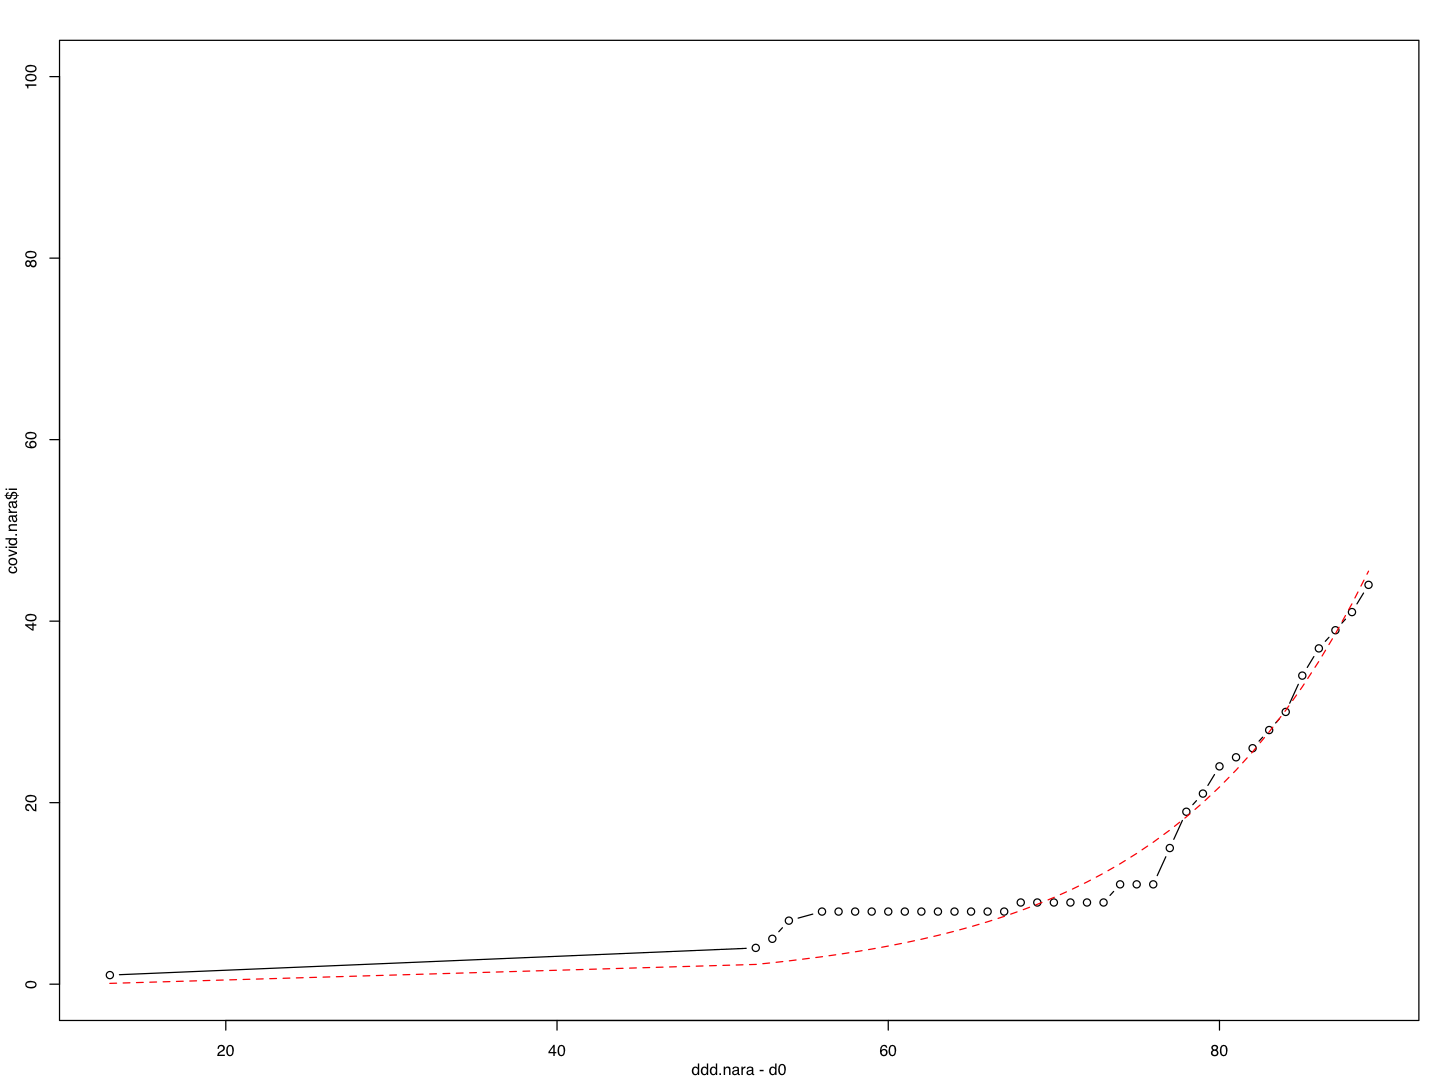

In [116]:
pred.nara <- pred_exp(ddd.nara-d0, cc_all, ll_all)

plotFigure(function(){
    plot(ddd.nara-d0, covid.nara$i, ylim=c(0,100), type="b")
    points(ddd.nara-d0, pred.nara, type="l",lty=2,col=2)    
})


## SEIR model

We assume a modified SEIR model. S: susceptible, E: exposed but not show symptoms yet, I: infected and separeted in a hospital, R: recovered and no more susceptible.

$$
\frac{dS}{dt} = -\alpha E S /N \\
\frac{dE}{dt} = \alpha E S/N - \beta E - \gamma E\\
\frac{dI}{dt} = \beta E - \gamma I \\
\frac{dR_E}{dt} = \gamma E, \\
\frac{dR_I}{dt} = \gamma I,
$$
where $N$ is the population of the country (Nara), $\alpha$ is an infection rate, $\beta$ is an onset rate, $\gamma$ is a recover rate.

In [852]:
e0 <- 30
i0 <- 10
r0 <- 0
par <- c(alpha=alpha, beta=alpha-gamma-ll_tmp, gamma=gamma, nn=1348e+3)

In [853]:
1/par[3]

gamma.gamma 
         38

In [854]:
nd <- 365
sst <- numeric(nd)
eet <- numeric(nd)
iit <- numeric(nd)
ret <- numeric(nd)
rit <- numeric(nd)
dit <- numeric(nd)

alpha <- par[1]
beta  <- par[2]
gamma <- par[3]
nn <- par[4]

ss <- nn
ee <- 100
ii <- 50
re <- 16
ri <- 16


Construct a simulator using poison and binomial random growth.

In [855]:
simSEIR <- function(nd, par){
    sst <- numeric(nd)
    eet <- numeric(nd)
    iit <- numeric(nd)
    ret <- numeric(nd)
    rit <- numeric(nd)
    dit <- numeric(nd)

    alpha <- par[1]
    beta  <- par[2]
    gamma <- par[3]
    nn <- par[4]

    ss <- nn
    ee <- 32
    ii <- 59
    re <- 16
    ri <- 16
    for(dd  in 1:nd){
        t1 <- rpois(1, ss/nn*ee*alpha)
        t2 <- rbinom(1, ee, beta)
        t3 <- rbinom(1, ee, gamma)
        t4 <- rbinom(1, ii, gamma)
        ss <- ss - t1
        ee <- ee + t1 - t2 - t3
        if(ee <= 0){
            ss <- ss - (1-ee)
            ee <- 1
        }
        ii <- ii + t2 - t4
        re <- re + t3
        ri <- ri + t4
        sst[dd] <- ss
        eet[dd] <- ee
        dit[dd] <- t2-t4
        iit[dd] <- ii
        ret[dd] <- re
        rit[dd] <- ri
    }    
    return(cbind(sst=sst,eet=eet,iit=iit,ret=ret,rit=rit,dit=dit))
}

In [888]:
alpha <- 0.42
gamma <- 1/38
alpha <- exp(tmp$par[1])
gamma <- exp(tmp$par[2])
sim.total <- simSEIR(365, par=c(alpha=alpha, beta=alpha-gamma-ll_tmp, gamma=gamma, nn=1e+8))

We will optimize the model parameter alpha and gamma, using the number of infected and recovered of total Japan in the period between 2/17 to 4/1.

The loss is defined by mean squared error of the number of infected and recovered population.

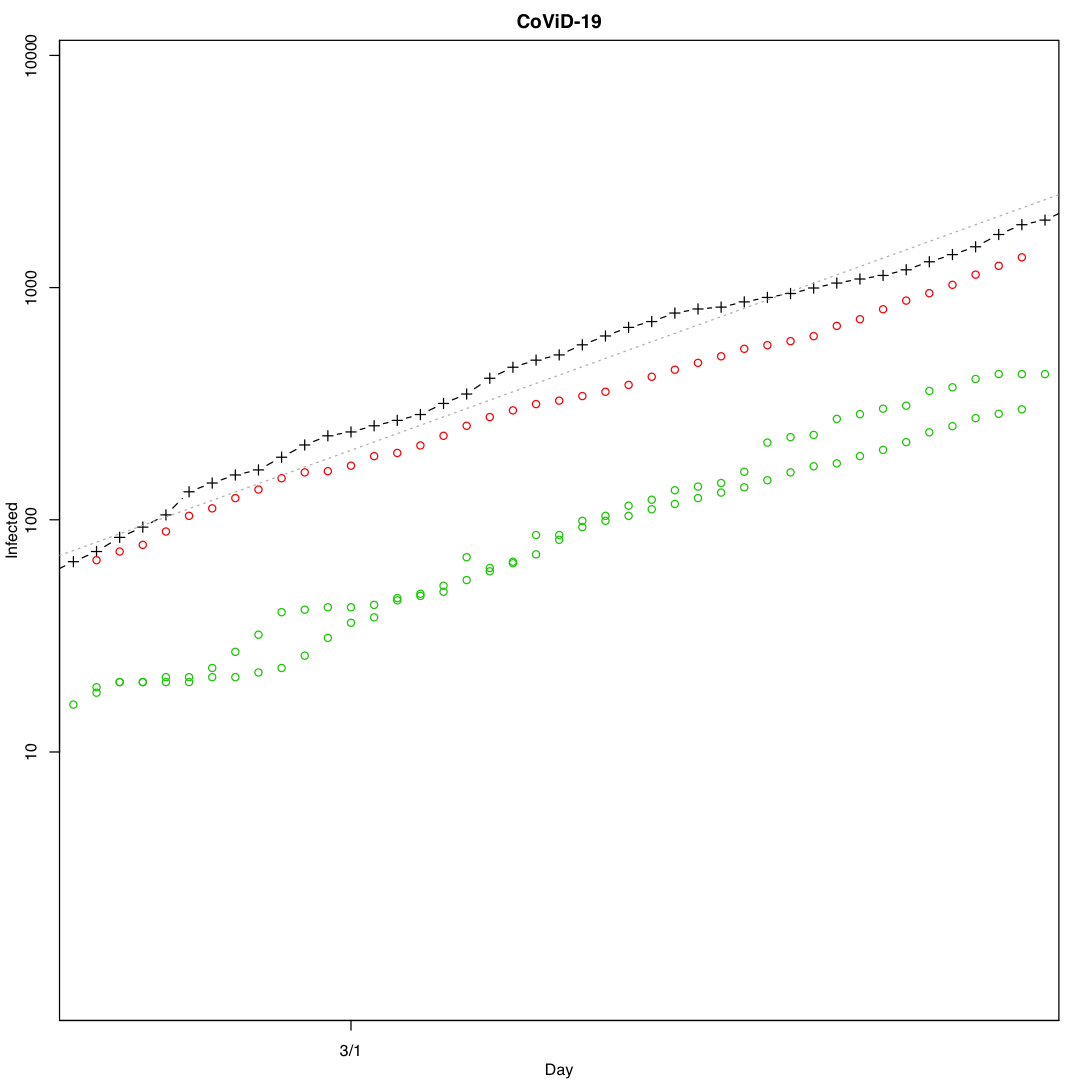

In [889]:
options(repr.plot.width=9, repr.plot.height=9)

plotFigure(function(){
    plot(dd1, logi, axes=FALSE, frame=TRUE, type="b", lty=2, pch=3,
         xlim=c(35,75),ylim=c(0,9), xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, log(covid$re), pch=1, col=3)

    points(35:75, log(sim.total[1:41,"iit"]), pch=1, col=2)
    points(35:75, log(sim.total[1:41,"rit"]), pch=1, col=3)
    
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))
    abline(model_exp_2, lty=3, col=8)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11"))


In [885]:
iii <- which(dd1 >= 33 & dd1 <= 75)
length(iii)
loss <- function(tmp){
    mean((log(covid$i[iii]) - log(tmp[1:length(iii),"iit"]))^2) + mean((log(covid$re[iii]) - log(tmp[1:length(iii),"rit"]))^2)
}
loss(sim.total)

[1] 43

[1] 0.2172745

Since the simulation is uses random variables and depends on initial growth drastically, we evaluated the loss using N=300 sample simulations with the same parameters.

In [943]:
lossn <- function(par, nl){
    iii <- which(dd1 >= 33 & dd1 <= 75)
    alpha <- exp(par["alpha"])
    gamma <- exp(par["gamma"])
    beta  <- alpha-gamma-ll_tmp
    nn <- 1e+8

    lll <- sapply(1:nl,function(par){
        sim.tmp <- simSEIR(365, par=c(alpha=alpha, beta=alpha-gamma-ll_kinki, gamma=gamma, nn=1e+8))
        loss(sim.tmp)
    })
    return(mean(lll))
}

In [944]:
lossn(c(alpha=log(0.42), gamma=log(1/38)), 300)

[1] 0.3326153

Now we can optimize alpha and gamma.

Beta is determined from alpha and gamma since we evaluated exponential growth of infected population.

Namely, when $E, I, R \ll N$, the growth will be $\lambda \simeq \alpha-\beta-\gamma$

In [945]:
tmp.sim <- optim(c(alpha=log(0.42), gamma=log(1/38)), function(par){lossn(par, 300)})
tmp.sim

$par
    alpha     gamma 
-1.049813 -4.003371 

$value
[1] 0.1514313

$counts
function gradient 
     301       NA 

$convergence
[1] 10

$message
NULL

In [971]:
alpha <- exp(tmp.sim$par[1])
gamma <- exp(tmp.sim$par[2])

beta <- alpha-gamma-ll_tmp
c(alpha, beta, gamma)
1/gamma[[1]]

alpha      alpha      gamma 
0.35000326 0.26117754 0.01825401

[1] 54.7825

The estimated recovery rate seems rather small compared with stay in the hospitals.

Show the prediction of entire Japan.

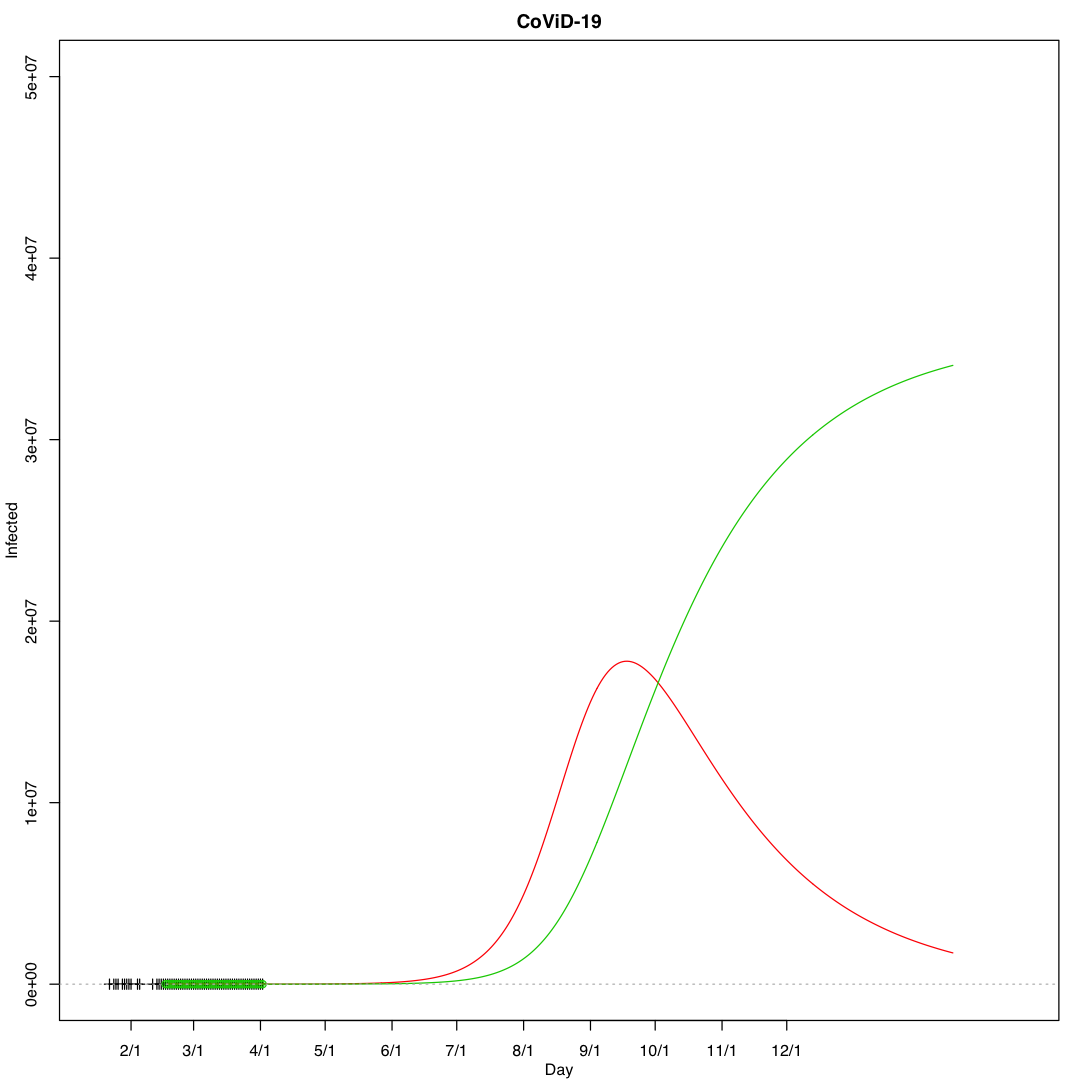

In [909]:
plotFigure(function(){
    plot(dd1, covid$i, axes=FALSE, frame=TRUE, type="b", lty=2, pch=3, xlim=c(1,430), ylim=c(0,5e+7),
         xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, covid$re, pch=1, col=3)

    points(1:365+33,(sim.total[,"iit"]), pch=1, col=2,type="l")
    points(1:365+33,(sim.total[,"rit"]), pch=1, col=3,type="l")
    
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2)
    abline(model_exp_2, lty=3, col=8)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11"))

In [987]:
max(sim.total[,"iit"])
which.max(sim.total[,"iit"])+d0+33


[1] 17792976

[1] 18Sep2020

## Nara 
Simulate dynamics of infection and recovery in Nara.

In [ ]:
hoge <- simSEIR(365, par=c(alpha=alpha, beta=alpha-gamma-ll_kinki, gamma=gamma, nn=1348e+3))


sim1.jpg 


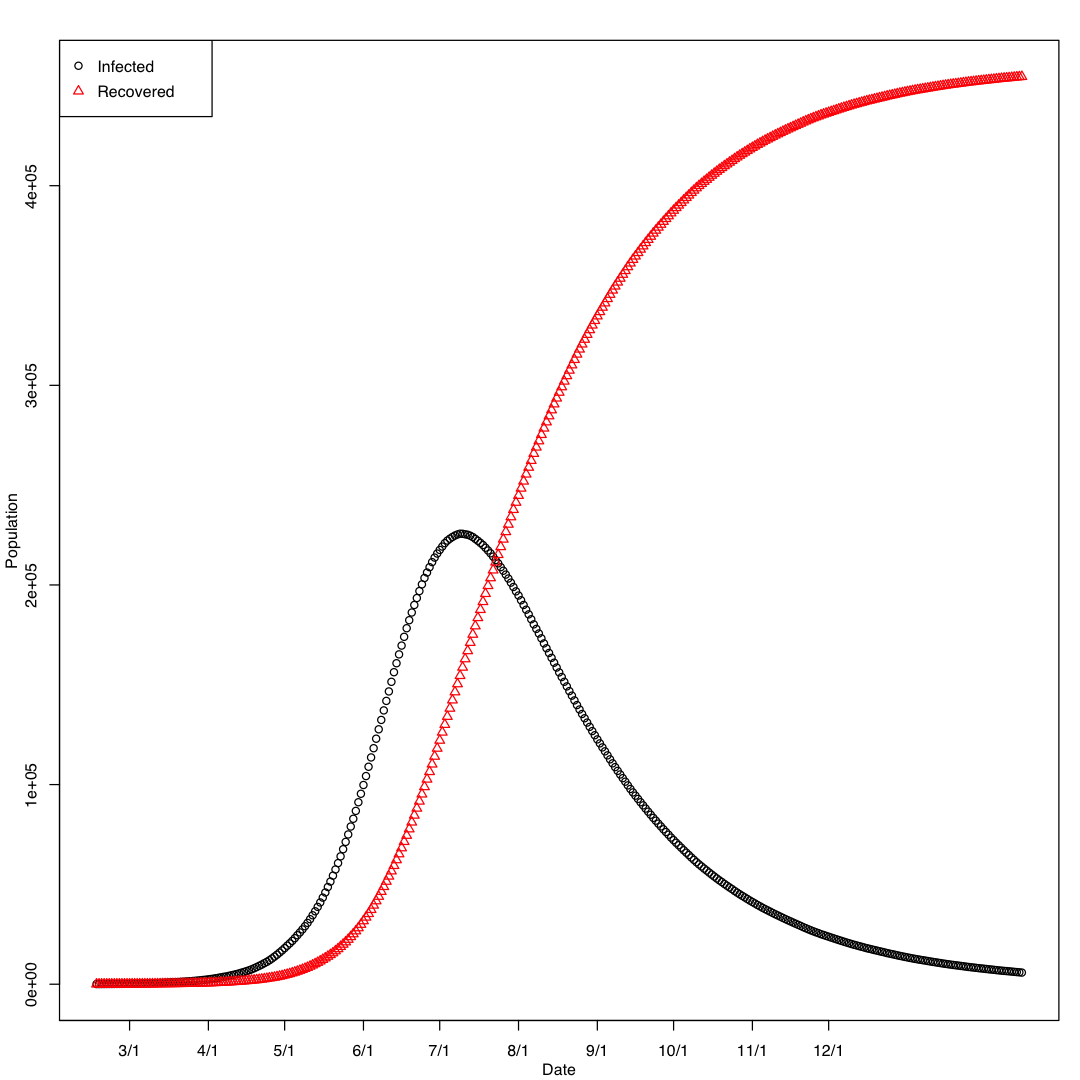

In [1017]:
mdlabel <- rbind(c(2, 1),
                 c(3, 1),
                 c(4, 1),
                 c(5, 1),
                 c(6, 1),
                 c(7, 1),
                 c(8, 1),
                 c(9, 1),
                 c(10, 1),
                 c(11, 1),
                 c(12, 1)
                )
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})
## label to plot ticks                                                                                    
ticklabel <- apply(mdlabel,1,paste,collapse="/")

plotFigure(function(){
    matplot(33:(32+365), hoge[,c("iit","rit")], type="b", pch=1:4, axes=FALSE, frame=TRUE, lty=3, xlab="Date",ylab="Population")
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2)
    legend("topleft",legend=c("Infected","Recovered"),pch=1:2, col=1:2)
}, rr=1.5, dir="fig", file="sim1", dev=c("x11","jpg"))

Since the simulation depends on random variables, compute 100 random samples to see the variation of the prediction.

In [984]:
alpha <- exp(tmp.sim$par[1])
gamma <- exp(tmp.sim$par[2])

sim100 <- sapply(1:100,function(nn){
    hoge <- simSEIR(365, par=c(alpha=alpha, beta=alpha-gamma-ll_kinki, gamma=gamma, nn=1348e+3))
    return(hoge[,"iit"])
})


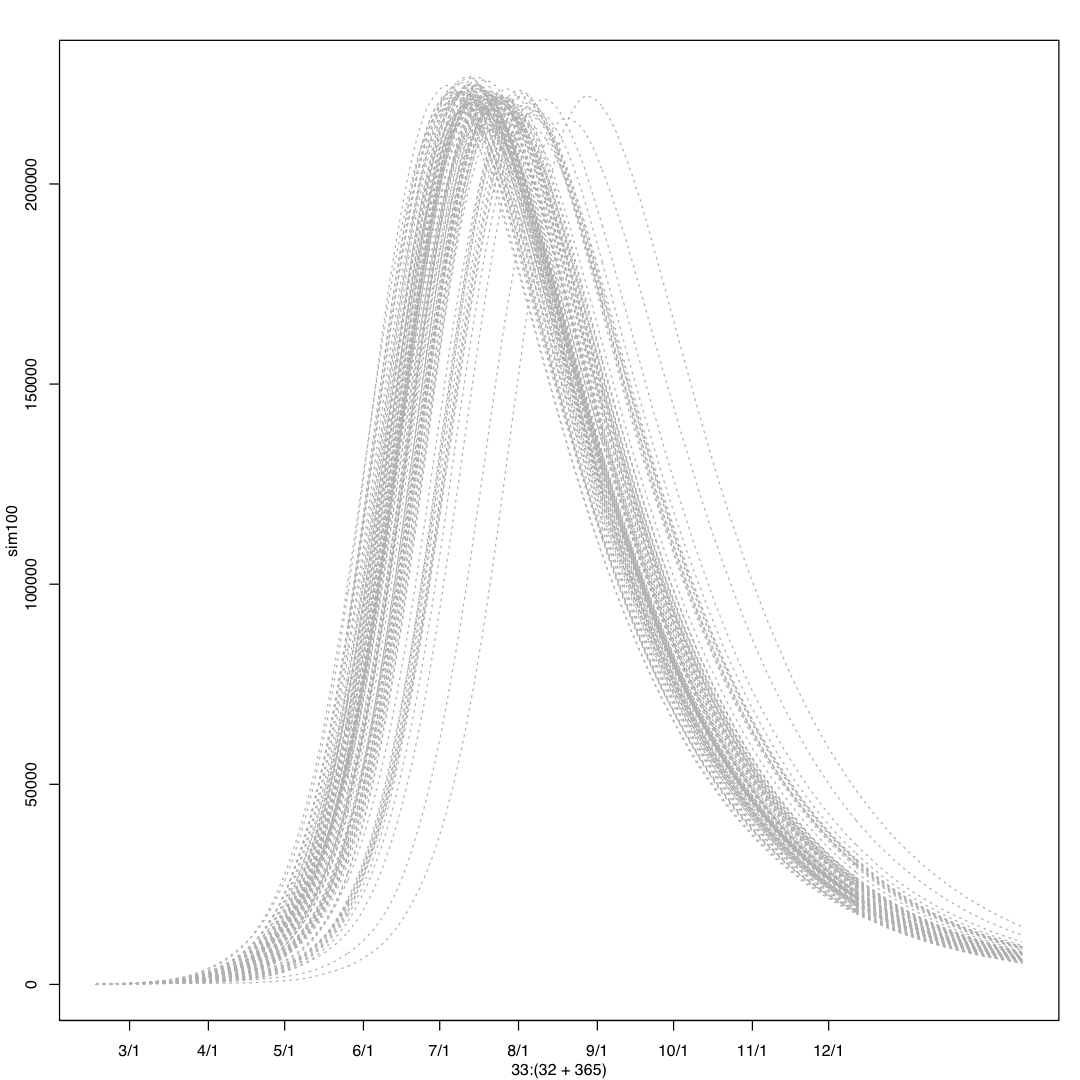

In [985]:
plotFigure(function(){
    matplot(33:(32+365), sim100, type="l", axes=FALSE, frame=TRUE, lty=3, col=8)
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2)
})

Histgram of the peak hieght and date of the peak.

hist.jpg 


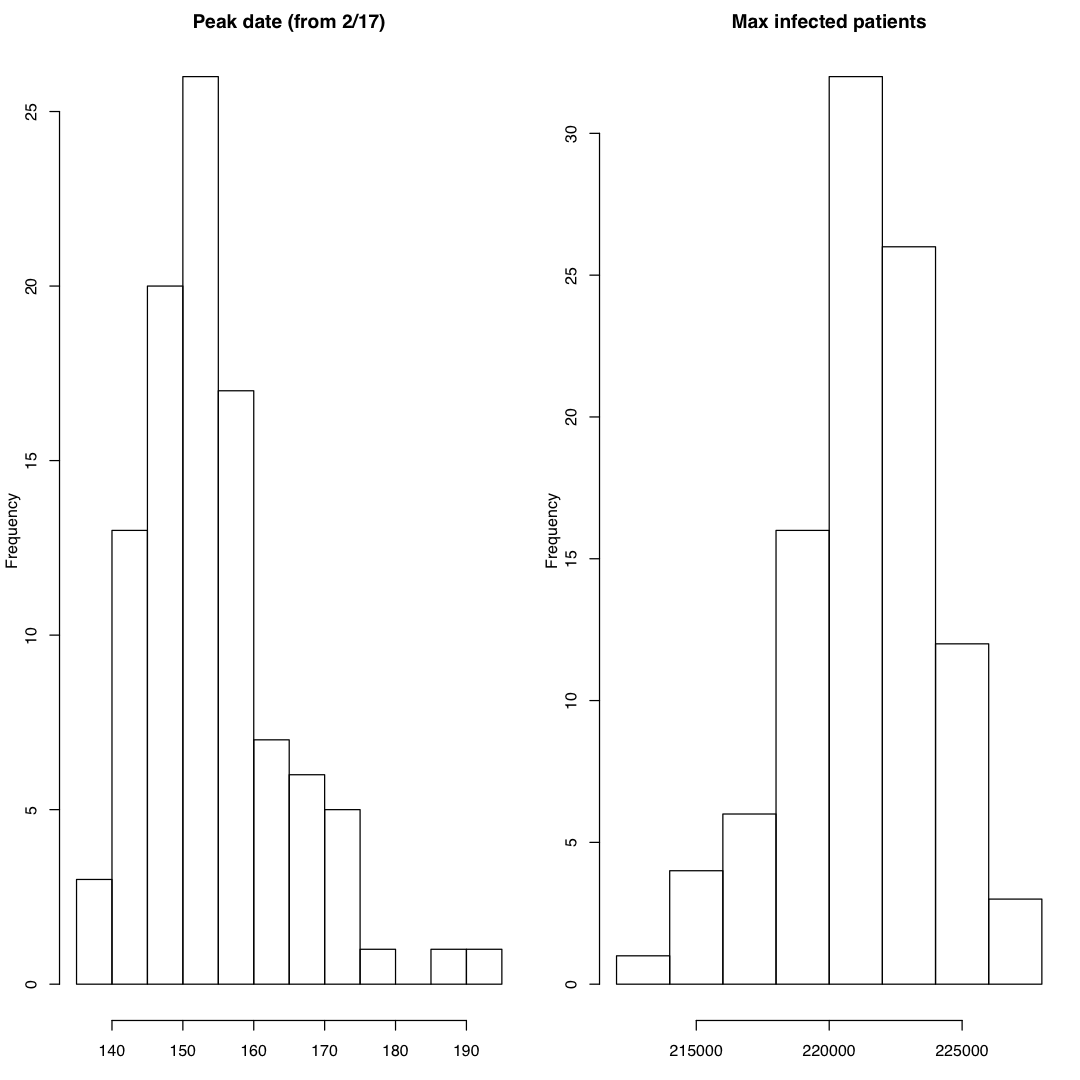

In [1020]:
plotFigure(function(){
    hist(apply(sim100,2,which.max),br=8, main="Peak date (from 2/17)",xlab=NA)
    hist(apply(sim100,2,max),br=8, main="Max infected patients", xlab=NA)
},np=2,rx=3,ry=1.5,dir="fig",file="hist",dev=c("x11","jpg"))
dmax <- median(apply(sim100,2,which.max))
abline(v=dmax, lty=3, col=8)

In [954]:
infmax <- apply(sim100,2,max)
mean(infmax)
sd(infmax)

[1] 221254.8

[1] 2774.532

In [955]:
daymax <- apply(sim100,2,which.max)
mean(daymax)
sd(daymax)

[1] 152.46

[1] 9.605785

In [956]:
dmax 
dmax + d0 + 33

[1] 151

[1] 17Jul2020

In [957]:
xxx <- 1:30
yyy <- log(sim100[1:30,1])
lm(yyy~xxx)


Call:
lm(formula = yyy ~ xxx)

Coefficients:
(Intercept)          xxx  
     4.1995       0.0818  


In [1022]:
exp(-0.0675059717400305*12)

[1] 0.4448262